In [1]:
# import library
import librosa 
from scipy.io import wavfile as wav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


# Inputs

In [2]:
# FULL DATA
AUDIO_FP = '../UrbanSound8K/audio/'
DATA_FFP = '../UrbanSound8K/metadata/UrbanSound8K.csv'

# Data preprocessing
Data require to normalised for consistency
- Audio channel
- sample rate
- bit depth

During the preprocessing, normalisation can be done using Librosa's load() function

In [3]:
# example audio file
sample = '/fold5/13577-3-0-2.wav'

# audio and sample rate
orig_sample_rate, orig_audio = wav.read(AUDIO_FP + sample)
lib_audio, lib_sample_rate = librosa.load(AUDIO_FP + sample)

# compare original vs  librosa (normalised) sample rate
print('Original sample rate:', orig_sample_rate) 
print('Librosa sample rate:', lib_sample_rate) 

Original sample rate: 44100
Librosa sample rate: 22050


In [4]:
# check bit depth
print('Original bit depth range min:', np.min(orig_audio)) 
print('Original bit depth range max:', np.max(orig_audio)) 
print('Librosa bit depth range min:', np.min(lib_audio))
print('Librosa bit depth range max:', np.max(lib_audio))

Original bit depth range min: -14956
Original bit depth range max: 15945
Librosa bit depth range min: -0.28959247
Librosa bit depth range max: 0.29703423


Text(0.5, 1.0, 'Original audio channel')

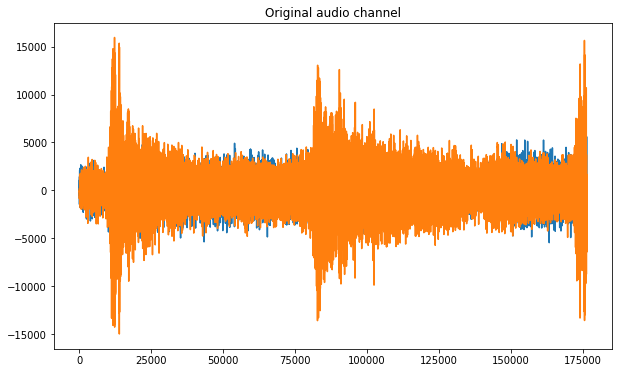

In [11]:
# audio channels comparison

# original audio
plt.figure(figsize=(10,6))
plt.plot(orig_audio)
plt.title('Original audio channel')

Text(0.5, 1.0, 'Librosa audio channel')

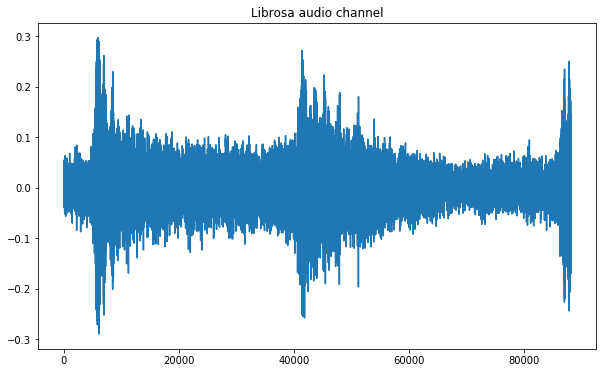

In [12]:
# librosa audio
plt.figure(figsize=(10,6))
plt.plot(lib_audio)
plt.title('Librosa audio channel')

[Observations]
- Librosa's load() function normalised everything
- it converts sample rate to 22050
- it normalised bit-depth to -1 to 1
- it merge 2 channels into 1 channel

### Mel-Frequency Cepstral Coefficients (MFCC) 

MFCC summarises the frequency distribution across the window size, so that it's possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow to identify features for classification. 

In [13]:
# mfcc() to generate MFCC from time series audio data
# this calculates a series of 40 MFCCs over 173 frames
mfccs = librosa.feature.mfcc(y=lib_audio, sr=lib_sample_rate, n_mfcc=40)
mfccs.shape

(40, 173)

### Data conversion and extract MFCC for each audio 

In [14]:
# read data
audio_data = pd.read_csv(DATA_FFP)

In [15]:
audio_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
data = []

for index, row in audio_data.iterrows():
    # audio full file name
    audio_ffn = os.path.join(os.path.abspath(AUDIO_FP),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    # class name, audio, sample rate, mfccs
    class_name = row['class']
    audio, sample_rate = librosa.load(audio_ffn, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # average mfccs
    mfccs_data = np.mean(mfccs.T,axis=0)
    
    # append
    data.append([mfccs_data, class_name])
    
# convert into dataframe
df_audio = pd.DataFrame(data, columns=['feature', 'class_name'])

In [17]:
df_audio.head()

,feature,class_name
0,"[-215.793, 71.66612, -131.81377, -52.091335, -...",dog_bark
1,"[-424.68686, 110.562294, -54.14824, 62.01074, ...",children_playing
2,"[-459.56473, 122.80033, -47.924713, 53.265697,...",children_playing
3,"[-414.55374, 102.89688, -36.66496, 54.18041, 0...",children_playing
4,"[-447.39703, 115.0954, -53.809113, 61.608585, ...",children_playing


### Convert data and labels using label encoder
Encode categorical data into numerical data

In [18]:
# label encoder
LabelEncoder = LabelEncoder()

# Convert features and class name into arrays
X = np.array(df_audio.feature.tolist())
y = np.array(df_audio.class_name.tolist())

# encode class name into numeric
y2 = to_categorical(LabelEncoder.fit_transform(y))

In [19]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [20]:
y2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Split into train test
Split data set into train/test set 80:20

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y2, 
                                                    test_size=0.2, 
                                                    random_state = 40)

In [22]:
x_train.shape

(6985, 40)

In [23]:
y_train.shape

(6985, 10)

In [24]:
x_test.shape

(1747, 40)

In [25]:
y_test.shape

(1747, 10)

Overall, there are 6985 training sets and 1747 testing sets  

In [28]:
# store data sets
%store x_train
%store y_train
%store x_test
%store y_test
%store y2
%store LabelEncoder

Stored 'x_train' (ndarray)
Stored 'y_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)
Stored 'y2' (ndarray)
Stored 'LabelEncoder' (LabelEncoder)
